# Gravitational wave detection with neural networks

[Joe Bayley](mailto:joseph.bayley@glasgow.ac.uk)
[Michael J Williams](mailto:m.williams.4@research.gla.ac.uk)

Institute for Gravitational Research 

University of Glasgow

<div style="text-align:center"><img src="https://raw.githubusercontent.com/mj-will/intro2ml/master/docs/assets/igr.jpg" width="100"/></div>

Machine learning, in particular deep learning methods have been demonstrated to be able to identify gravitational wave signals quite effectively. A few notable examples for detections with LIGO include:
[Gabbard et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.141103) where convolutional neural networks are used to detect simulated signals from binary black hole coalescence in noisy data. 


In this tutorial we will use a basic convolutional neural network to identify some massive black hole binary signals within LISA data.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jcbayley/lisamlworkshop/blob/main/lisa_workshop_detection.ipynb)

The data set is a simplified parameter space for MBHB as the more complex the parameter space, the more data is needed and a more complex network is likely needed. 

In this example we will be using Massive Black Hole Binary signals, and have the condition that they do not overlap and that they exist purely within coloured Gaussian noise based on a projected LISA PSD. This simplifies the problem greatly for the case of detection. Also to reduce the complexity of the problem, many of the parameters for the MBHB will be fixed and only some ramdomly sampled, this again reduces the size of the parameter space and the complexity of the problem.

### Prior space

The prior space for the MBHB is defined in the table below:

| name| symbol| range| info|
|-----|-----|-----|-----|
|component mass | $m_1, m_2$| $[5\times10^5, 5\times10^6]$ $M_{\odot}$| |
|dimensionless spin | $\chi_{1,2}$| $0$| |
|Luminosity distance |$D_L$| $[5\times10^3, 10^4]$ Mpc| |
|merger time |$t_c$| $0.75T$| |
|inclination | $\theta_{jn}$ | $0$| angle between total angular momentum (J) and line of sight(n)|
|phase at merger | $\phi_c$ | $0$| |
|polarisation | $\psi$ | $0$| |
|longitude | $\phi$ | $0$| |
|cos latitude |$\cos \theta$| $0$| |

To reduce the size of the dataset further and simplify the problem for this notebook, we have also used a low sampling rate and duration

| name| value|
| -----| ---- |
| sampling frequency| $1$ mHz|
| duration | $1024000$ s (~11 days)|

We also choose to use the TDI outputs X,Y,Z as input to the network

# Installing and importing libraries

If running this tutorial locally, see the [readme](https://github.com/jcbayley/lisamlworkshop/blob/main/README.md) for installation instructions.

In [1]:
# Install packages if not already installed
try:
    import bilby
except ImportError:
    !pip install bilby[gw]
    !pip install pytdi
    !pip install scikit-learn
    !pip install scipy
    !pip install lisagwresponse
    # Kill the kernel so the list of packages updates
    import os
    os.kill(os.getpid(), 9)

We have to restart the kernel after installing the packages. The previous cell will kill the kernel, so you now need to rerun the cells.

In [2]:
import os
import numpy as np
import scipy
import scipy.signal
import matplotlib.pyplot as plt
import h5py
import pickle

import torch
import bilby
import pytdi.michelson
import lisagwresponse
from sklearn import metrics
import seaborn as sns

sns.set_context("notebook")
sns.set_palette("colorblind")


## Downloading the data



In [3]:
def fetch_data(url, filename):
    """Fetch data from a url and save it to given file"""
    if not os.path.isfile(filename):
        import urllib
        urllib.request.urlretrieve(url, filename=filename)
    else:
        print("File already exists!")

In [4]:
os.makedirs("data", exist_ok=True)
orbits_url = "https://github.com/jcbayley/lisamlworkshop/raw/main/data/esa-orbits-1-0-2.h5"
orbits_file = "data/esa-orbits-1-0-2.h5"
fetch_data(orbits_url, orbits_file)
# Now for the training data
data_url = "https://github.com/jcbayley/lisamlworkshop/raw/main/data/sig_noise_data_0_2000.h5"
data_file = "data/sig_noise_data.h5"
fetch_data(data_url, data_file)


File already exists!
File already exists!


# Matched Filter

In this section we will look at how to generate a waveform and we will use the bilby package, which is primarily a parameter estimation library, however has some useful data generation tools.

Below is a function which uses the IMRPhenomD waveform generator, which generates binary black hole waveforms without precession, higher modes or individual component spins, to create the two polarisation (plus and cross) of a gravitational wave waveform.


In [5]:
def create_polarisations(injection_parameters, sampling_frequency, start_time, duration, minimum_frequency=1e-6):
    """ Generates the polarisations of signal.
    """
    # Fixed arguments passed into the source model 
    waveform_arguments = dict(waveform_approximant="IMRPhenomD",
                              reference_frequency=1e-3, 
                              minimum_frequency=minimum_frequency,
                              maximum_frequency=sampling_frequency/2.0)

    # Create the waveform_generator using a LAL BinaryBlackHole source function
    waveform_generator = bilby.gw.WaveformGenerator(
        duration=duration, sampling_frequency=sampling_frequency,
        frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
        parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
        waveform_arguments=waveform_arguments,
        start_time=start_time)
    
    # extract waveform from bilby
    waveform_generator.parameters = injection_parameters
    # get the time domain strain
    time_signal = waveform_generator.time_domain_strain()

    return time_signal

In [6]:
injection_parameters = {
    "mass_1": 1e6,              # solar masses
    "mass_2": 1e6,              # solar masses
    "chi_1": 0,                 # unitless effective spin 
    "chi_2": 0,
    "luminosity_distance": 2e3, # Mpc
    "theta_jn": 0,              # 
    "phase": 0,
    "polarisation": 0,
    "lon": 0,                   # radians
    "lat":0                     # radians
}

In [7]:
sampling_frequency = 0.001 # low sampling frequency to keep number of samples low
waveform_start_time = 22160.0 # start time is just after the orbits file starts
waveform_duration = 10000000 # set the duration of the waveform 
data_duration = waveform_duration # can set the data duration to be a smaller section of waveform if necessary
data_start_time = waveform_start_time + waveform_duration - data_duration + 0.25*data_duration # place the data start time of reponse such that the merger in 0.25 seconds before the end

In [8]:
# compute the array of times for the waveform and data 
waveform_times = np.arange(waveform_start_time, waveform_start_time + waveform_duration, 1./sampling_frequency)
data_times = np.arange(data_start_time, data_start_time + data_duration, 1./sampling_frequency)

In [9]:
# use bibly to create some IMRPhenomD waveforms
pol = create_polarisations(injection_parameters, sampling_frequency, waveform_start_time, waveform_duration, minimum_frequency=8e-5)

12:03 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


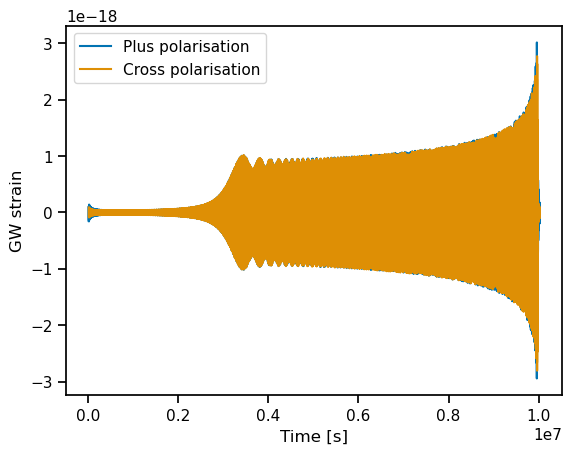

In [10]:
fig, ax = plt.subplots()
ax.plot(waveform_times, pol["plus"], label = "Plus polarisation")
ax.plot(waveform_times, pol["cross"], label = "Cross polarisation")
ax.set_xlabel("Time [s]")
ax.set_ylabel("GW strain")
ax.legend()
plt.show()

In [11]:
# generate the lisa response at some times (data_times) given some waveform polarisations and sky position and orbits
data = lisagwresponse.ReadStrain(waveform_times,                          # times at which the polarisations were generated
                                pol["plus"],                              # plus polarisations
                                pol["cross"],                             # cross polarisations
                                gw_beta=injection_parameters["lat"],      # latitude of source (ecliptic frame)
                                gw_lambda=injection_parameters["lon"],    # longitude in source
                                orbits=orbits_file,                       # orbits file for lisa
                                size = data_duration*sampling_frequency,  # number of samples in output responses
                                dt = 1./sampling_frequency,               # separation of response samples
                                t0 = data_start_time)                     # start time of the response outputs

In [12]:
# compute the lisa response from one of the links at the specified times
resp = data.compute_gw_response(data_times, data.LINKS)

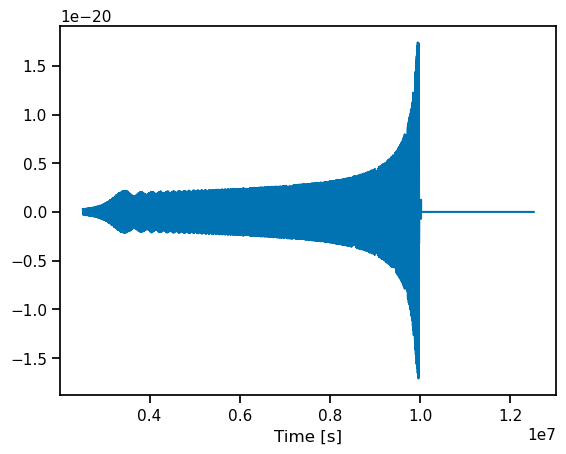

In [13]:
fig, ax = plt.subplots()
ax.plot(data_times, resp[:,0])
ax.set_xlabel("Time [s]")
plt.show()

In [14]:
# to use pytdi with the outputs of lisagwresponse one needs to write the response to a file
data.write(path=f"./test_gw_0.h5",mode="w")

In [15]:
# initialise the tdi class with the response and orbits files
tdi_data = pytdi.Data.from_gws("./test_gw_0.h5", orbits="./data/esa-orbits-1-0-2.h5", skipped=200)

In [16]:
# compute the X tdi
X2 = pytdi.michelson.X2.build(**tdi_data.args)
X2_signal = X2(tdi_data.measurements)

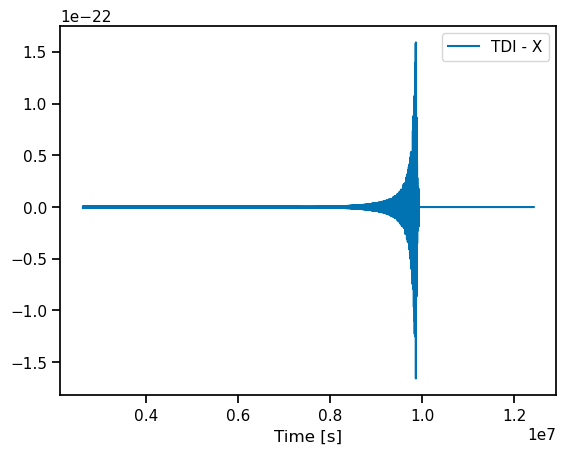

In [17]:
fig, ax = plt.subplots()
ax.plot(data_times[100:-100], X2_signal, label="TDI - X")
ax.set_xlabel("Time [s]")
ax.legend()
plt.show()

In [18]:
psd_mag = (2e-21)**2       # set a fixed psd magnitude
Nt = len(X2_signal)        # define length of time series
dt = 1./sampling_frequency # sample separation
resp_duration = Nt*dt      # time duration 
df = 1./resp_duration      # frequency separation


In [19]:
# create some noise based on psd 
sigma = np.sqrt(Nt*psd_mag/(2*dt)) # define frequency domain standard deviation for discrete fft
noise_fs = 0.5*sigma*(np.random.normal(0,1,size=Nt//2 + 1) + 1j*np.random.normal(0,1,size=Nt//2 + 1)) # generate complex Gaussian noise
noise_ts = np.fft.irfft(noise_fs) # inverse fft to get time series
data_X2 = X2_signal + noise_ts # add signal to noise

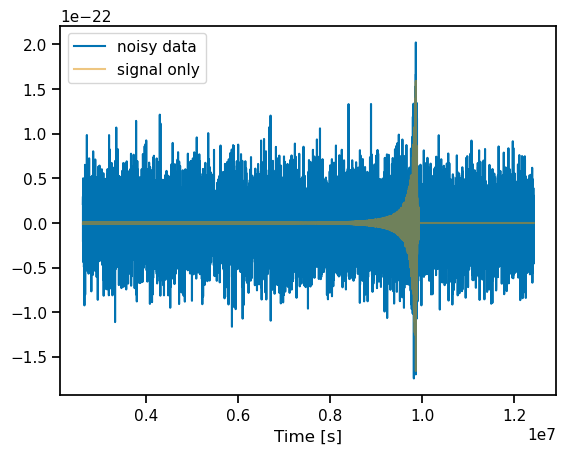

In [20]:
fig, ax = plt.subplots()
ax.plot(data_times[100:-100], data_X2, label="noisy data")
ax.plot(data_times[100:-100], X2_signal, alpha=0.5, label="signal only")
ax.legend()
ax.set_xlabel("Time [s]")
plt.show()

In [ ]:
# generate  time frequency spectrogram of the noisy signal
spect = scipy.signal.spectrogram(data_X2, fs=sampling_frequency, nperseg=128, noverlap=32)

In [ ]:
fig, ax = plt.subplots()
ax.imshow(spect[2], origin="lower")
plt.show()

Compute the matched filter we can use
$$ (s | h) = 4 {\rm Re} \int_{0}^{\infty} \frac{\tilde{s}(f) \tilde{h}^*(f)}{S_{n(f)}}df $$
The matched filter is then defined as 
$$ \rho = \frac{(s|h)}{\sqrt{(h|h)}} $$
Where $\tilde{s}(f)$ is the Fourier transformed detector data, $\tilde{h}^*(f)$ is the complex conjugate of the fourier transformed waveform and $S_{n}(f)$ is the noise power spectral density of the detector.
We can find the SNR timeseries using
$$ \rho(t) = \frac{4}{\sqrt{(h|h)}} {\rm Re} \int_{0}^{\infty} \frac{\tilde{s}(f) \tilde{h}^*(f)}{S_{n}(f)} e^{2\pi i f t}df$$

We can implement this as below

In [21]:
def compute_snr_timeseries(filter, data, psd, dt):
    # define come constants
    Nt = len(filter)
    data_duration = Nt*dt

    # compute data ffts
    detector_fft = np.fft.rfft(data) * dt
    waveform_fft = np.fft.rfft(filter) * dt
    
    #compute complex conjugate
    finner =  np.conj(waveform_fft) * detector_fft / psd
    #compute the optimal SNR
    osnr_sum = 4 / data_duration * np.sum(np.conj(waveform_fft) * waveform_fft / psd)
    # compute matched filter SNR for optimal waveform
    snr_sum = 4 / data_duration * np.sum(finner) / np.sqrt(osnr_sum)

    # compute the SNR timeseries
    snr_time = 4 / data_duration * 0.5*Nt * np.fft.irfft(finner)/ np.sqrt(osnr_sum)

    # roll the timeseries so template times match up
    return np.roll(snr_time, -int(0.25*data_duration*sampling_frequency)), snr_sum, np.sqrt(osnr_sum)

In [22]:
snr_time, matched_snr, opt_snr = compute_snr_timeseries(X2_signal, data_X2, psd_mag, dt)
print("Matched filter SNR: ", np.real(matched_snr))
print("Optimal SNR : ", np.real(opt_snr))

Matched filter SNR:  20.210776896128973
Optimal SNR :  19.917053167034094


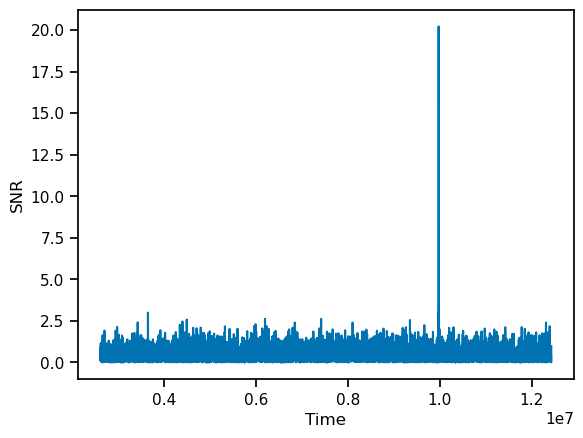

In [23]:
fig, ax = plt.subplots()
ax.plot(data_times[100:-100], abs(snr_time))
#ax.plot(data_times[100:-100], abs(snr2.data), alpha = 0.5)
ax.set_xlabel("Time")
ax.set_ylabel("SNR")
plt.show()

# Machine Learning approach

## Data

The data consists of time series which will be labelled `x` and labels (no signal/signal) labelled `y`. The dimensions of the time series array will be:
`[number of time series, tdi channels, number of samples]`
We will change the dataset to match the default of torch which is to put the channels last to that:
`[number of time series, number of samples, tdi channels]`

The number of samples with depend on the duration and sampling rate, in this example the data is one "1 month" and sampled at 1Hz.


In [24]:
def load_data(data_file):
    """Load the data"""
    # load the data
    with h5py.File(data_file, 'r') as f:
        x = np.array(f["whitened_data"])
        y = np.array(f["parameters"])
    return x,y

| var | |
|----|----|
|x | data|
|y | parameters|

In [26]:
x, y = load_data(data_file)

In [27]:
np.shape(x), np.shape(y)

((2000, 3, 1024), (2000, 6))

Looking at the parameters we can see that the data is not mixed but all the signals are first, then noise.

In [28]:
y[:,0]

array([1., 1., 1., ..., 0., 0., 0.])

It is good to mix the data up first, otherwise you can run into problems when training. 

In [29]:
randidx = np.arange(len(x))
np.random.shuffle(randidx)

x = x[randidx]
y = y[randidx]

In [30]:
y[:,0]

array([1., 0., 1., ..., 0., 0., 0.])

Once the data is loaded plot one of the time series.

As mentioned before the sampling rate `fs` is 1 mHz and the duration is 1024000 seconds (~11days).

In [31]:
fs = 0.001                          # sampling frequency
duration = 1024000                  # duration in seconds
t = np.arange(0, duration, 1. / fs) # array of time steps

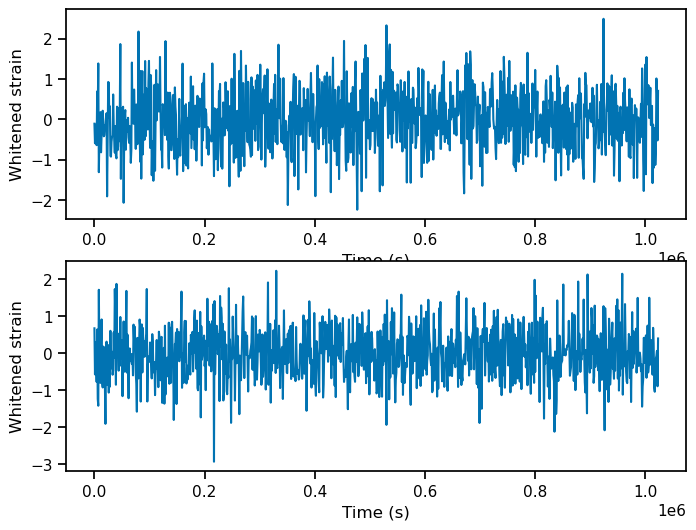

In [32]:
fig, ax = plt.subplots(nrows=2,figsize=(8,6))
ax[0].plot(t, x[np.where(y[:,0]==1)[0][8], 0])
ax[1].plot(t, x[np.where(y[:,0]==0)[0][0], 0])
for i in range(2):
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Whitened strain")
plt.show()

You will notice that the data is scaled to have values around 1 (in this case it is just Gaussian noise with a standard deviation of 1).

This is an important step when training any neural network - the data preparation.

The outputs after TDI are very small (~$10^{-22}$), therefore to rescale them, we whiten the data using a projected LISA power spectral density (PSD). In this case it is the same PSD that we used to generate the data, however in practice this is usually measured from the data. 
For this method of machine learning it is not as important that the measured PSD used for whitening is an accurate representation of the real PSD, as long as we perform the same data preparation beforehand and use realistic data the network should learn the underlying distribution.

### Labels

In their original forms the labels are simply a list of zeros and ones with zero corresponding to no signal and one correponding to signal. We want the trained neural network to predict these labels as accurately as possible.


In this dataset we also include some of the parameters associated with the MBHB, The NaN values here are the empty signal parameter slots for the noise only data sets.

In [33]:
print(f'Label vector: {y[:3]}')

Label vector: [[1.00000000e+00 1.30396821e+06 1.30396821e+06 9.64771624e+03
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00            nan            nan            nan
             nan            nan]
 [1.00000000e+00 4.82929923e+06 4.82929923e+06 6.75231995e+03
  0.00000000e+00 0.00000000e+00]]


### Training/testing split

The data is generally split into three components training, validation and test data. The training data is used to train the network and update the weights, the validation data is used to test the outputs of the network during training (the weights are not updated with this data). Finally the test data is used at the end of training to test the performance of the network.

In this case we reserve 10% of the data for validation and 10% for test. This can be adjusted as you wish, in general the more training data the better.

In [34]:
n_train = int(0.8 * x.shape[0])
n_val = int(0.1 * x.shape[0])
x_train, x_val, x_test = x[:n_train], x[n_train:n_train+n_val], x[n_train:n_train+2*n_val]
y_train, y_val, y_test = y[:n_train, 0], y[n_train:n_train+n_val, 0], y[n_train:n_train+2*n_val, 0]


## General parameters

We need to define some general parameters for networks we're going to use:

* Batch size: refers to the number of images/samples passed to the network in a single instance of training
* Input shape: defines the shape of the input to the network, the batch size is ignored so we only specify the number of channels(detectors) and the length of the time series.
* Epochs: refers to the number of times the network will train on the complete dataset



In [35]:
batch_size = 128            # number of samples in each batch of training data
input_shape = [3, 1024]     # shape of the data
n_epochs = 20               # number of epochs to train for

## The model

We now need to construct the neural network that we're going to training to classify the data.

We start by defining the type of pytorch model. In this case we're using `Sequential`. When using this type of model any layers we add are assumed to directly follow from the previous one. 

In this case we're going to use a 1D covolutional layer (`Conv1d`) layer. We need to specify the number of neurons, the size of the filter (or kernel), the activation function and the shape of the input. When running this it is a good idea to check if the channels come first or last, in this case we have channels first. i.e. `[batch_size, n_channels, n_samples]` rather than `[batch_size, n_samples, n_channels]`.

We then add 1D Max-pooling which will reduce the dimensions of data being passed to the next layer by taking the maximum value in blocks of a given size (in this case 2).

We the repeat the convolution + max-pooling combination again.

This is followed by a `Linear` layer (or fully-connected or Dense (Keras)), which requires a flat input so we also add a flattening layer. For dense layer we only need to specifiy the number of neurons and the activation function. This flattens the inputs from `[batch_size, n_channels, n_samples]` to `[batch_size, n_samples]`.

Finally the output layer. Since this is a classifcation task we want the network to predict one of the two classes, so we use two neurons. As for the activation function, we use a softmax function since this ensures the sum of all the output is one, so they can be thought of as a sort of probability.

You can print what GPUs are available

In [36]:
print(torch.cuda.device_count())

0


We can then select the GPU that we want to use

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [38]:
model = torch.nn.Sequential(
          torch.nn.Conv1d(3,16,8,padding="same"), # [input channels, number of filters, filter size]
          torch.nn.ReLU(),
          torch.nn.MaxPool1d(2),                  
          torch.nn.Conv1d(16,64,8,padding="same"),
          torch.nn.ReLU(),
          torch.nn.MaxPool1d(2),
          torch.nn.Conv1d(64,8,8,padding="same"),
          torch.nn.ReLU(),
          torch.nn.MaxPool1d(2),
          torch.nn.Flatten(),
          torch.nn.LazyLinear(512), # LazyLinear automatically computes the input size from flattened convolutions
          torch.nn.ReLU(),
          torch.nn.LazyLinear(128),
          torch.nn.ReLU(),
          torch.nn.LazyLinear(2)
        ).to(device)


/home/csantos/.conda/envs/t1mldetection/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Loss and optimiser

It's at this stage that we specify the loss function to use and what optimiser to use.

The **optimiser** is the algorithm that is used to explore the parameter space of the network weights. In this example we're going to use `Adam` with a learning rate of 0.001 and the other parameters left as their default values. There a various different optimisers to choose from but Adam has proven to be realiable for a wide variety of problems and is a good place to start.

We then need to define the function that will quantify the network's performance, the **loss function**. In this case we're using **Categorical Crossentropy**. This combined with the **Softmax layer** means the network will ouput a vector of probabilities for each samples where each probability corresponds to a particular class.

For this binary (noise/signal) case it can written as:

$$f(\theta) = - \sum_{i \in S} log(\theta_{i}^{S}) - \sum_{i \in N} log(\theta_{i}^{N})$$

where $\theta_{i}^{S/N}$ is the predicted probability of class signal-noise (S) or noise-only (N)


In [39]:
loss_func = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)

## Data setup

In [40]:
training_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))    # convert training data to tensor dataset
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)  # create a `dataloader`

val_dataset = torch.utils.data.TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Training

We're now ready to train the network. We can write a small function which performs the training on each batch of data.

A portion of the data (the validation set) is used to keep track of the networks performance during training. Importantly it is never used to update the networks parameters.

In [41]:
def train_batch(x_batch, y_batch, train=True):
    """ Train one batch of data"""
    model.train(train)
    if train:
        optimiser.zero_grad()
    # send data to the device
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    # compute outputs of the model
    outputs = model(x_batch)
    # compute the loss after putting them through a softmax activation to normalise them between 0 and 1
    loss = loss_func(outputs.softmax(dim=1), y_batch.to(torch.long))

    outputs = (outputs[:, 1] > 0.5).float()
    correct = (outputs == y_batch).float().sum().cpu().numpy()
    accuracy = 100 * correct / len(y_batch)
    
    # if training compute the gradients and update the optimizer based on those gradients
    if train:
        loss.backward()
        optimiser.step()
    return loss, accuracy

We can look at the training loss and validation loss as a function of time to see if the networks has trained

In [42]:
%%time
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
# loop over the training function above for each epoch and batch
for epoch in range(n_epochs):
    for x_batch,y_batch in train_loader: # Loop over the batches
        train_loss,train_acc = train_batch(x_batch, y_batch, train=True) # put batches on device and run train function
    train_losses.append(train_loss.detach().cpu().numpy())
    train_accuracy.append(train_acc)

    # also compute loss/accuracy for the validation without computing gradients
    with torch.no_grad():
        for x_batch,y_batch in val_loader:
            val_loss,val_acc = train_batch(x_batch, y_batch, train=False) # run same training loop but do not update weights
    val_losses.append(val_loss.detach().cpu().numpy())
    val_accuracy.append(val_acc)

    print(f"Epoch: {epoch}, Train Loss: {train_loss}, Validation Loss: {val_loss}")

/home/csantos/.conda/envs/t1mldetection/lib/python3.9/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1666642881969/work/aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 0, Train Loss: 0.5856770277023315, Validation Loss: 0.6649320125579834


Epoch: 1, Train Loss: 0.5541910529136658, Validation Loss: 0.42836129665374756


Epoch: 2, Train Loss: 0.5092042088508606, Validation Loss: 0.48481306433677673


Epoch: 3, Train Loss: 0.45573702454566956, Validation Loss: 0.4203872084617615


Epoch: 4, Train Loss: 0.4388276934623718, Validation Loss: 0.40055274963378906


Epoch: 5, Train Loss: 0.4242270588874817, Validation Loss: 0.3647569417953491


Epoch: 6, Train Loss: 0.35055509209632874, Validation Loss: 0.42665964365005493


Epoch: 7, Train Loss: 0.4817412197589874, Validation Loss: 0.3768053352832794


Epoch: 8, Train Loss: 0.36137697100639343, Validation Loss: 0.41459548473358154


Epoch: 9, Train Loss: 0.43605804443359375, Validation Loss: 0.4167357385158539


Epoch: 10, Train Loss: 0.3704741895198822, Validation Loss: 0.41736873984336853


Epoch: 11, Train Loss: 0.37863829731941223, Validation Loss: 0.4470170736312866


Epoch: 12, Train Loss: 0.3555111289024353, Validation Loss: 0.39697879552841187


Epoch: 13, Train Loss: 0.3764030337333679, Validation Loss: 0.46945783495903015


Epoch: 14, Train Loss: 0.39041388034820557, Validation Loss: 0.4139942526817322


Epoch: 15, Train Loss: 0.3518727421760559, Validation Loss: 0.4258088767528534


Epoch: 16, Train Loss: 0.3291827142238617, Validation Loss: 0.37671589851379395


Epoch: 17, Train Loss: 0.3799145817756653, Validation Loss: 0.3711271286010742


Epoch: 18, Train Loss: 0.36050552129745483, Validation Loss: 0.4369027316570282


Epoch: 19, Train Loss: 0.3612327575683594, Validation Loss: 0.37035420536994934
CPU times: user 40.1 s, sys: 2.76 s, total: 42.8 s
Wall time: 10.8 s


## Evaluation

Now that the network in trained we can analyse the output to understand how well it has learn to predict the classes.

### Loss function

We can plot the values of the loss function we calculated to see how network learned over the epochs, we can also include the validation set which was never used to train the network.

The validation curve can inform us if the network has over trained on the training data and not correctly learnt the underlying signal model.


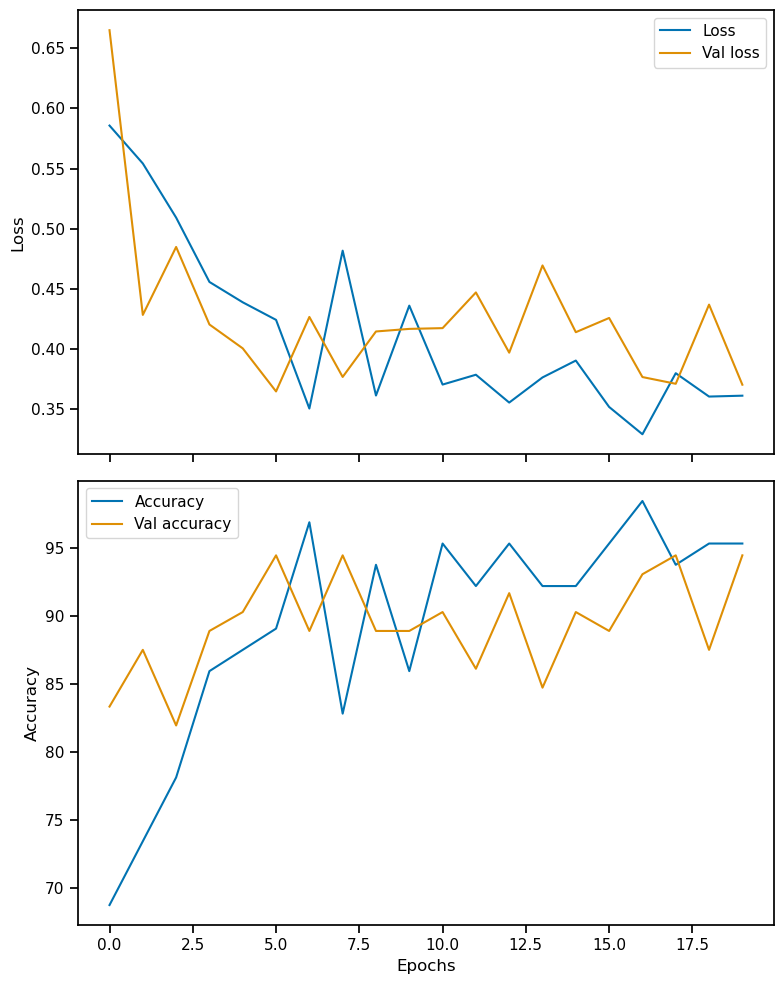

In [43]:
# set up the figure
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
axs = axs.ravel()     # flattens the array of axes so it's easier to index
# plot the loss
axs[0].plot(np.arange(n_epochs), train_losses, label='Loss')
axs[0].plot(np.arange(n_epochs), val_losses, label='Val loss')
# plot accuracy
axs[1].plot(np.arange(n_epochs), train_accuracy, label='Accuracy')
axs[1].plot(np.arange(n_epochs), val_accuracy, label='Val accuracy')
# labels
axs[1].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

### Predictions

We can easily get predictions for the testing set or any other data we might have using the trained model. We will use these to quantify the networks performance.

Its a good idea to plot some of your test data to confirm that it appears similar to the training set, this can often be an issue when many transformations are made to the data.

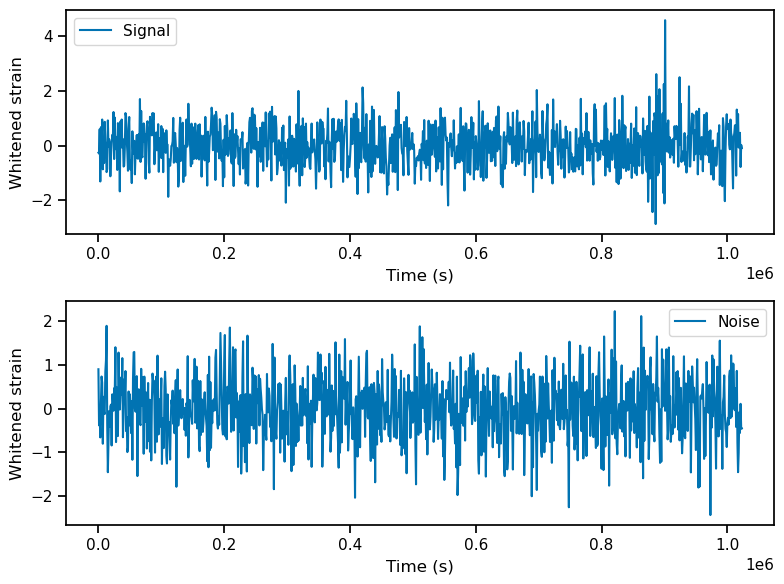

In [44]:
fig, ax = plt.subplots(nrows=2,figsize=(8,6))
ax[0].plot(t, x_test[np.where(y_test==1)[0][0], 0], label="Signal")
ax[1].plot(t, x_test[np.where(y_test==0)[0][0], 0], label="Noise")
for i in range(2):
    ax[i].set_xlabel("Time (s)")
    ax[i].set_ylabel("Whitened strain")
    ax[i].legend()
plt.tight_layout()
plt.show()

Make you predicitions!

In [45]:
with torch.no_grad():
    x_test_tensor = torch.FloatTensor(x_test).to(device)
    y_pred = model(x_test_tensor).cpu()

Find the indices where the signals and noise are and plot the network outputs after passing through a softmax function.

In [46]:
noiseinds = np.where(y_test == 0)[0]
signalinds = np.where(y_test == 1)[0]

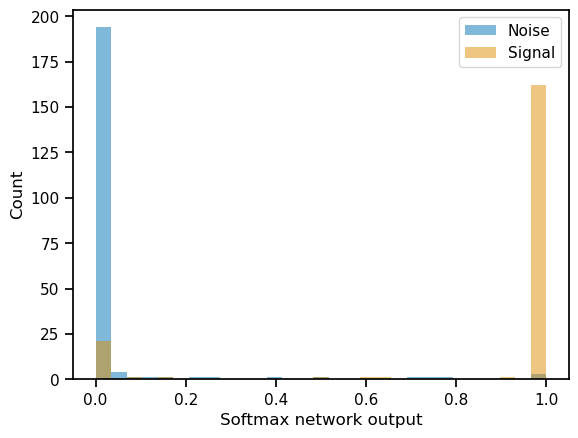

In [47]:
fig, ax = plt.subplots()
bins = np.linspace(0,1,30)
ax.hist(y_pred[noiseinds].softmax(-1)[:,1], alpha=0.5, bins=bins, label="Noise")
ax.hist(y_pred[signalinds].softmax(-1)[:,1], alpha=0.5, bins=bins, label="Signal")
ax.set_xlabel("Softmax network output")
ax.set_ylabel("Count")
ax.legend()
plt.show()

We can also look at the outputs before passing through a softmax, which can sometimes work as a better statistic.

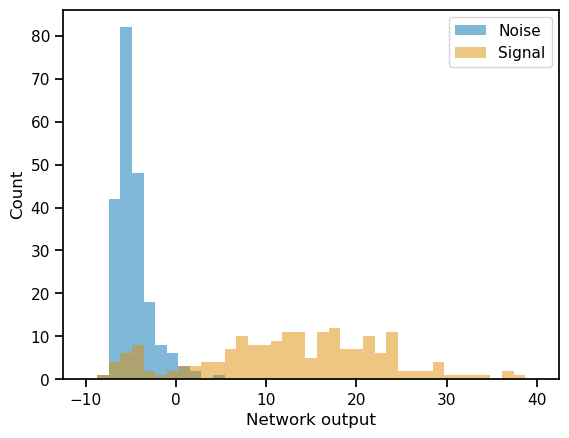

In [48]:
fig, ax = plt.subplots()
bins = np.linspace(-10,40,40)
ax.hist(y_pred[noiseinds,1], alpha=0.5, bins=bins, label="Noise")
ax.hist(y_pred[signalinds,1], alpha=0.5, bins=bins, label="Signal")
ax.set_xlabel("Network output")
ax.set_ylabel("Count")
ax.legend()
plt.show()

### Confusion matrix

A confusion matrix allows us to visualise what classes the network is predicting correctly or incorrectly.

In this case we may want to minimise the number of false positives (noise classified as signal) rather than maximise the number of true positives.

Scikit-learn includes lots of useful functions to compute metrics like confusion matrices and ROC curves (which we will see later on)

In order to compute the confusion matrix we need the predicted classes rather than their probabilites. We get these by simply taking the class with the maximum probability for each time series.

In [49]:
pred_class = np.argmax(y_pred, axis=1)
true_class = np.argmax(np.array([[0,1] if yt==1 else [1,0] for yt in y_test]), axis=1)

We can now compute the confusion matrix

In [50]:
cm = metrics.confusion_matrix(true_class, pred_class)

In [51]:
cm/sum(cm)

array([[0.89473684, 0.04069767],
       [0.10526316, 0.95930233]])

## ROC curves

Reciever operator characteristic curves are another way of quatifying the network's performance. It's a plot of the true positive rate (probability of detection) against the false positive rate (probabilty of false alarm).

We use Scikit learn again to compute the ROC curve, but this time we use the probabilites instead of the classes. Importantly we use the probability of the a time series being a signal (the second column in the matrix representation).

In [52]:
# [:, 1] for second column
fa, ta, _ = metrics.roc_curve(y_test, y_pred[:,1])

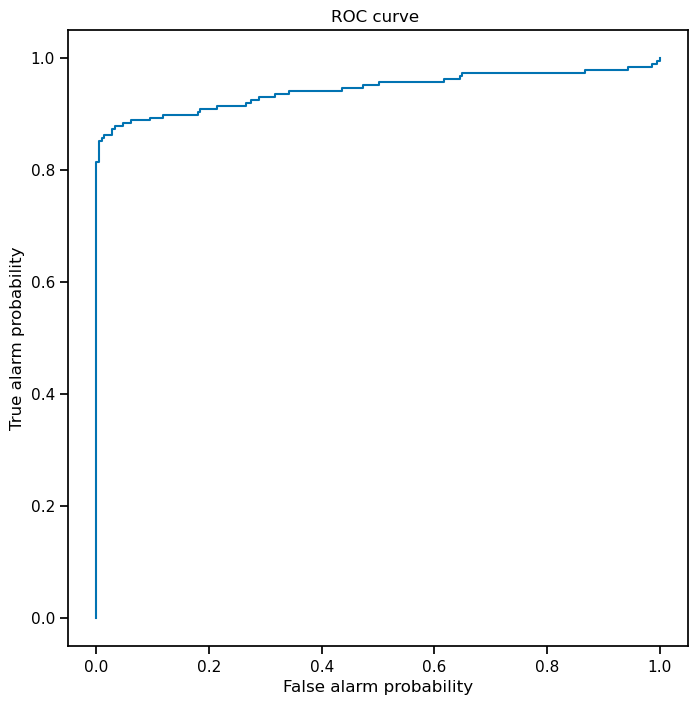

In [53]:
fig = plt.figure(figsize=(8,8))
plt.plot(fa, ta)
plt.xlabel('False alarm probability')
plt.ylabel('True alarm probability')
plt.title('ROC curve ')
plt.show()

## Detection Threshold

One can empirically estimate a detection threshold by setting a false alarm rate (say 1%) and measuring the statistic based on many examples of the noise.

Below we get the network outputs for all the noise only inputs, arange them in order of value and take the value where 1% of the outputs is larger (i.e. 1% falsa alarm)

In [54]:
perc1_fa = sorted(y_pred[noiseinds,1])[int(0.99*len(y_pred[noiseinds,1]))]

In [55]:
sum(y_pred[:,1]<perc1_fa)

tensor(235)

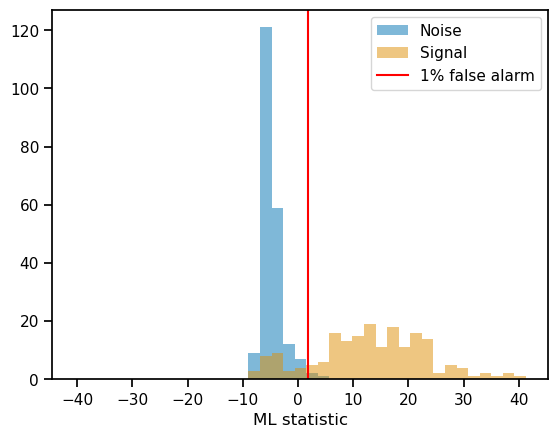

In [56]:
fig, ax = plt.subplots()
bins = np.linspace(y_pred.min(), y_pred.max(), 40)
ax.hist(y_pred[noiseinds,1], alpha=0.5, label="Noise", bins=bins)
ax.hist(y_pred[signalinds,1], alpha=0.5, label="Signal", bins=bins)
ax.axvline(perc1_fa, color="red", label="1% false alarm")
ax.set_xlabel("ML statistic")
ax.legend()
plt.show()

# Try yourself 🌊🏆

Try and write some code to produce point estimates of some of the parameters of the waveforms as well as a detection statistic.
i.e. try and predict the mass as well.

To estimate the parameters we need many examples of the data associated with the parameters. For the training set that has been provided the labels are saved as ["class", "mass_1", "mass_2", "luminosity_distance", "dec", "ra"] where class refers to signal or no signal.
We use the "class" in the previous step for classification, but now you can try and predict some of the parameters.
Be aware that because of the parmaeter space we have chosen, the dec and ra should be fixed values.

You will need to write the model as a class to allow for both loss functions, an example of how to do this is here: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html#define-the-class